# LSTM则学习每天的时间序列，从而预测未来的行为。
- LSTM Long Short-Term Memory 长短期记忆网络，适合时间序列预测的行为

**这是一个相对复杂的深度学习应用，适用于需要分析大量序列数据的场景。**

## 如果遇到报错`CUDA out of memory`，内核-关闭所有内核，或调小`batch`参数

## 1. 数据预处理

In [13]:
import torch
import cv2
import numpy as np

from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer, Masking, BatchNormalization, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.metrics import RootMeanSquaredError


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import os

from concurrent.futures import ThreadPoolExecutor, as_completed


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. 数据转换为LSTM模型的输入格式
** 每一个时间点的数据都包括前n个时间步长的数据**

In [137]:
import pandas as pd
import numpy as np

# 每个时间步是10分钟
csv_path = 'datasets/erp_pdd_2009_2016.csv'
df = pd.read_csv(csv_path)
df

,Date Time,A,B,C,D,E,F,G,H,I,J,K,L,M,N
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


In [138]:
# 每1个小时的数据
df = df[5::6]
df

,Date Time,A,B,C,D,E,F,G,H,I,J,K,L,M,N
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420521,31.12.2016 19:10:00,1002.18,-0.98,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6
420527,31.12.2016 20:10:00,1001.40,-1.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4
420533,31.12.2016 21:10:00,1001.19,-2.75,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7
420539,31.12.2016 22:10:00,1000.65,-2.89,270.22,-7.15,72.30,4.93,3.57,1.37,2.22,3.57,1288.03,0.35,0.68,216.7


In [139]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
df[:26]

,Date Time,A,B,C,D,E,F,G,H,I,J,K,L,M,N
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
2009-01-01 06:00:00,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
2009-01-01 07:00:00,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
2009-01-01 08:00:00,01.01.2009 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
2009-01-01 09:00:00,01.01.2009 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2


Date Time
2009-01-01 01:00:00   -8.05
2009-01-01 02:00:00   -8.88
2009-01-01 03:00:00   -8.81
2009-01-01 04:00:00   -9.05
2009-01-01 05:00:00   -9.63
                       ... 
2016-12-31 19:10:00   -0.98
2016-12-31 20:10:00   -1.40
2016-12-31 21:10:00   -2.75
2016-12-31 22:10:00   -2.89
2016-12-31 23:10:00   -3.93
Name: B, Length: 70091, dtype: float64

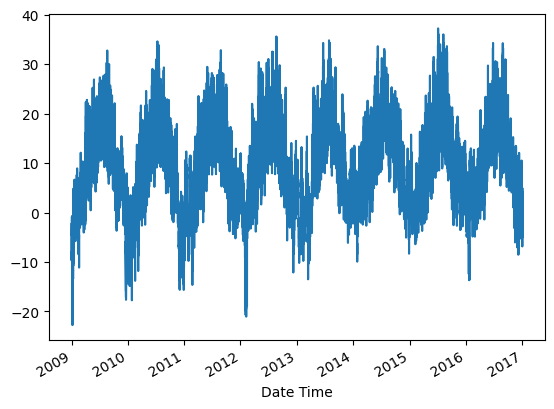

In [142]:
temp = df['B']
temp.plot()
temp

In [151]:
temp_df = pd.DataFrame({'B':temp})
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df

,B,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09
...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09
2016-12-31 20:10:00,-1.40,1.483215e+09
2016-12-31 21:10:00,-2.75,1.483219e+09


In [152]:
# 以一年为周期性数据
day = 24*60*60
year = (365.2425)*day

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day))
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year))
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year))
temp_df

,B,Seconds,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,1.230775e+09,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,1.230779e+09,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,1.230782e+09,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,1.230786e+09,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...,...
2016-12-31 19:10:00,-0.98,1.483211e+09,-0.953717,0.300706,0.006900,0.999976
2016-12-31 20:10:00,-1.40,1.483215e+09,-0.843391,0.537300,0.007617,0.999971
2016-12-31 21:10:00,-2.75,1.483219e+09,-0.675590,0.737277,0.008334,0.999965


In [153]:
temp_df = temp_df.drop('Seconds', axis=1)
temp_df

,B,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...
2016-12-31 19:10:00,-0.98,-0.953717,0.300706,0.006900,0.999976
2016-12-31 20:10:00,-1.40,-0.843391,0.537300,0.007617,0.999971
2016-12-31 21:10:00,-2.75,-0.675590,0.737277,0.008334,0.999965


In [155]:
# 选择列 A 到 N 种类, 如 A 表示插拔, B 表示开关, C 表示电源线...
columns_to_add = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
selected_columns = df[columns_to_add]

# 将选定的列与 temp_df 合并
p_temp_df = pd.concat([selected_columns, temp_df], axis=1)

p_temp_df

,A,C,D,E,F,G,H,I,J,K,L,M,N,B,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0,-9.63,0.965926,0.258819,0.012916,0.999917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 19:10:00,1002.18,272.01,-5.36,72.00,5.69,4.09,1.59,2.54,4.08,1280.70,0.87,1.36,190.6,-0.98,-0.953717,0.300706,0.006900,0.999976
2016-12-31 20:10:00,1001.40,271.66,-6.84,66.29,5.51,3.65,1.86,2.27,3.65,1281.87,1.02,1.92,225.4,-1.40,-0.843391,0.537300,0.007617,0.999971
2016-12-31 21:10:00,1001.19,270.32,-6.90,72.90,4.99,3.64,1.35,2.26,3.63,1288.02,0.71,1.56,158.7,-2.75,-0.675590,0.737277,0.008334,0.999965


In [171]:
# [[[1], [2], [3], [4], [5], [6], [7]]] [8]
# [[[2], [3], [4], [5], [6], [7], [8]]] [9]
# [[[3], [4], [5], [6], [7]], [8], [9]] [10]

# 将数据转换为 X, y, 其中 X 为前7个时间窗口输入数据, y 为输出数据 14 种类别
def df_to_X_y(df, window_size=7):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1], df_as_np[i+window_size][2], df_as_np[i+window_size][3], df_as_np[i+window_size][4], df_as_np[i+window_size][5], df_as_np[i+window_size][6], df_as_np[i+window_size][7], df_as_np[i+window_size][8], df_as_np[i+window_size][9], df_as_np[i+window_size][10], df_as_np[i+window_size][11], df_as_np[i+window_size][12], df_as_np[i+window_size][13]]
    y.append(label)
  return np.array(X), np.array(y)

In [173]:
# 时序数据的一般格式 time、x 和 y 列
# 使用检测到的数据来训练,  X 是输入序列，y 是对应的目标输出, 输出2个值
dropout_rate = 0.2  # dropout比例

WINDOW_SIZE = 7 # window_size 窗口大小, 每次用前7个时间步的数据来预测下一个时间步的行为, 这里temp是温度数据, 压力数据
X1, y1 = df_to_X_y(p_temp_df)
X1.shape, y1.shape

((70084, 7, 18), (70084, 14))

## 将数据集拆分为训练集和测试集

In [174]:
X_train, y_train = X1[:60000], y1[:60000]
X_val, y_val = X1[60000:65000], y1[60000:65000]
X_test, y_test = X1[65000:], y1[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 7, 18),
 (60000, 14),
 (5000, 7, 18),
 (5000, 14),
 (5084, 7, 18),
 (5084, 14))

In [175]:
p_training_mean = np.mean(X_train[:, :, 0])
p_training_std = np.std(X_train[:, :, 0])

temp_training_mean = np.mean(X_train[:, :, 1])
temp_training_std = np.std(X_train[:, :, 1])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - p_training_mean) / p_training_std
  X[:, :, 1] = (X[:, :, 1] - temp_training_mean) / temp_training_std
  return X

def preprocess_output(y):
  y[:, 0] = (y[:, 0] - p_training_mean) / p_training_std
  y[:, 1] = (y[:, 1] - temp_training_mean) / temp_training_std
  return y


In [176]:
preprocess(X_train)
preprocess(X_val)
preprocess(X_test)

array([[[-1.07355644e+00,  1.12172468e+00,  1.32300000e+01, ...,
          2.58819045e-01,  5.22877889e-01, -8.52407598e-01],
        [-1.00807435e+00,  1.06696235e+00,  1.31400000e+01, ...,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [-9.51080673e-01,  9.21317857e-01,  1.30000000e+01, ...,
          7.07106781e-01,  5.21655371e-01, -8.53156301e-01],
        ...,
        [-8.80748054e-01,  7.33727754e-01,  1.28600000e+01, ...,
          9.65925826e-01,  5.20431780e-01, -8.53903251e-01],
        [-8.29817537e-01,  5.99734823e-01,  1.27300000e+01, ...,
          1.00000000e+00,  5.19819584e-01, -8.54276068e-01],
        [-8.01927015e-01,  5.35651247e-01,  1.25500000e+01, ...,
          9.65925826e-01,  5.19207120e-01, -8.54648446e-01]],

       [[-1.00807435e+00,  1.06696235e+00,  1.31400000e+01, ...,
          5.00000000e-01,  5.22266764e-01, -8.52782169e-01],
        [-9.51080673e-01,  9.21317857e-01,  1.30000000e+01, ...,
          7.07106781e-01,  5.21655371e

In [177]:
preprocess_output(y_train)
preprocess_output(y_val)
preprocess_output(y_test)

array([[ -0.7934386 ,   0.47273283,  12.15      , ...,   1.12      ,
        136.4       ,  12.93      ],
       [ -0.76312281,   0.41214472,  11.59      , ...,   1.88      ,
        190.2       ,  12.43      ],
       [ -0.72189335,   0.3783552 ,  11.65      , ...,   0.88      ,
        153.4       ,  12.17      ],
       ...,
       [  1.48145784,  -1.53366567,  -6.9       , ...,   1.56      ,
        158.7       ,  -2.75      ],
       [  1.41597574,  -1.54531723,  -7.15      , ...,   0.68      ,
        216.7       ,  -2.89      ],
       [  1.35049365,  -1.66066766,  -8.09      , ...,   1.        ,
        202.6       ,  -3.93      ]])

## 3. 使用 Keras库來构建LSTM 模型与训练

In [179]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l1_l2

# Custom Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x, self.W) + self.b)  # Energy
        a = tf.nn.softmax(e, axis=1)  # Attention weights
        output = tf.reduce_sum(x * a, axis=1)  # Weighted sum of input features
        return output

# 构建一个更复杂的双向LSTM模型，同时引入注意力机制, 使用检测到的数据进行训练。模型包括多层LSTM、Dropout、BatchNormalization等层
# input_shape=(time_steps, num_features)
def create_bilstm_attention_model(input_shape, dropout_rate=0.2):
    inputs = Input(shape=input_shape)
    masked_inputs = Masking(mask_value=0.0)(inputs)  # Add a Masking layer
    lstm_out = Bidirectional(LSTM(256, return_sequences=True))(masked_inputs)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)

    lstm_out = Bidirectional(LSTM(128, return_sequences=True))(lstm_out)
    # 添加 Dropout 和 BatchNormalization 层
    lstm_out = Dropout(dropout_rate)(lstm_out)
    lstm_out = BatchNormalization()(lstm_out)

    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(lstm_out)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    
    # 添加 GRU 层，units=64
    gru_out = GRU(units=64, return_sequences=True)(lstm_out)
    gru_out = Dropout(dropout_rate)(gru_out)
    gru_out = BatchNormalization()(gru_out)

    # Correct usage of Attention layer
    attention = Attention()(gru_out)

    # 全连接层，将 LSTM 的输出映射到32个神经元，并应用 ReLU 激活函数来引入非线性
    dense_out = Dense(32, activation='relu')(attention)
    dense_out = Dense(8, activation='linear')(dense_out)
    
    # 输出层，输出的y值 lables A -N 14个类别
    outputs = Dense(14)(dense_out)  # The final Dense layer outputs 14 values 最后的全连接层，输出14个值
    
    model = Model(inputs, outputs)
    
    # 使用Adam优化器(梯度下降优化)和均方误差（MSE）作为损失函数，衡量预测值与实际值之间差异的指标，值越小，表示模型的预测效果越好
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy', RootMeanSquaredError()])

    # 显示模型摘要
    model.summary()
    return model


In [180]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Eval 评估函数
def evaluate_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    # 均方根误差（RMSE）是一种用于衡量预测值与实际值之间差异的指标，值越小，表示模型的预测效果越好。 
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    # 平均绝对误差（MAE）
    mae = mean_absolute_error(y_test, y_pred)
    # R^2 分数
    r2 = r2_score(y_test, y_pred)
    
    return rmse, mse, mae, r2

## 4. 训练LSTM模型并选择最佳模型

In [112]:
import tensorflow as tf
import coremltools as ct
import onnx
import tf2onnx
import joblib

import datetime
import os

import json

import logging

# 配置日志记录器
logging.basicConfig(
    level=logging.INFO,  # 设置日志级别为 INFO
    format='%(asctime)s - %(levelname)s - %(message)s',  # 设置日志格式
    handlers=[
        logging.StreamHandler(),  # 输出到控制台
        logging.FileHandler('erp-train-model.log')  # 输出到文件
    ]
)

# 获取当前日期和时间
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M")

# 记录变量信息
logging.info(f"time_steps: {WINDOW_SIZE}")
logging.info(f"feature_len: 1")
logging.info(f"dropout_rate: {dropout_rate}")

# 检查 X_train 的形状
print(f"X_train shape: {X_train.shape}, num_samples: {X_train.shape[0]}, window_size: {X_train.shape[1]}, feature_len: {X_train.shape[2]}")

# 确保目标数据的形状与模型的输出形状一致
# 目标数据的形状应该是 (batch_size, x, feature_len)
print(f"y_train shape: {y_train.shape}")
#y_train = np.reshape(y_train, (y_train.shape[0], predict_times, feature_len))
#print(f"y_train shape: {y_train.shape}, num_samples: {y_train.shape[0]}, window_size: {y_train.shape[1]}, feature_len: {y_train.shape[2]}")

# 校验数据集
calibration_data = X_train[:int(len(X_train) * 0.1)]  # 取前10%的样本
# 保存为NPZ文件
np.savez('model_lstm_calibration_data.npz', data=calibration_data)

# 模型训练
# LSTM模型的輸入形狀: X_train.shape[1] 是window_size，X_train.shape[2] num_features是指定目标的特征值
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = create_bilstm_attention_model(input_shape, dropout_rate)

# 定义回调函数
# Add Tensorboard
tb_callback = TensorBoard(log_dir='./tb_results', histogram_freq=0, write_graph=True, write_images=True)

# EarlyStopping：监控val_loss，如果50个epoch内没有改善，则停止训练，并恢复至最佳模型权重。
# ReduceLROnPlateau：当val_loss停止改善时，将学习率降低一半。
# ModelCheckpoint：在每个epoch后保存最佳模型
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
model_checkpoint = ModelCheckpoint(
    filepath=f'models/best_erp_lstm_model_{current_time}.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
#model_checkpoint = ModelCheckpoint(f'best_lstm_yolo_model_{current_time}.tensorflow.keras', monitor='val_accuracy', save_best_only=True, mode='max')

# 拟合nn训练模型: 整个数据集上训练4000次，每次训练32个样本，validation_data 在每个 epoch结束后计算验证集的损失
history = lstm_model.fit(X_train, y_train, 
                epochs=100,
                batch_size=32,
                validation_data=(X_val, y_val),
                callbacks=[tb_callback, reduce_lr, model_checkpoint, early_stopping])


# 选择最佳模型
# 训练过程中每个 epoch 的验证损失值
val_loss = history.history['val_loss']
# 验证损失最小的 epoch 对应就是最佳模型, 保存为lstm_weights_xx.h5文件
best_epoch = np.argmin(val_loss)
best_model = load_model(f'models/best_erp_lstm_model_{current_time}.keras', custom_objects={'Attention': Attention})
best_model.save(f'models/best_erp_lstm_model_{current_time}.h5')  # 保存整个模型

# 将 Keras 模型转换为 ONNX 格式
spec = (tf.TensorSpec((None, X_train.shape[1], X_train.shape[2]), tf.float32, name="input"),)
output_path = f'models/best_erp_lstm_model_{current_time}.onnx'
model_proto, _ = tf2onnx.convert.from_keras(best_model, input_signature=spec, opset=13)
with open(output_path, "wb") as f:
    f.write(model_proto.SerializeToString())
print(f"模型成功保存为 ONNX 格式，路径为: {output_path}")

# Convert the model to tflite.
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model.
with open(f'models/best_erp_lstm_model_{current_time}.tflite', 'wb') as f:
  f.write(tflite_model)

## 转换Core ML 模型
# 定义输入
sequence_input = ct.TensorType(shape=(1, X_train.shape[1], X_train.shape[2]))

# 进行模型转换
coreml_model = ct.convert(
    best_model,
    convert_to="mlprogram", # mlprogram
    inputs=[sequence_input]
)

# 写入元数据
#coreml_model.input_description["input_1"] = "输入序列数据"
#coreml_model.output_description["output_1"] = "模型输出"

# 模型作者
coreml_model.author = "hello"

# 许可
coreml_model.license = "TODO: Add your license"

# 描述
coreml_model.short_description = "TODO: Add a short description of this model"

# 版本号
coreml_model.version = "1.0"

# 存储模型
coreml_output_path = f'models/best_erp_lstm_model_{current_time}.mlpackage'
coreml_model.save(coreml_output_path)
print(f"模型成功保存为 CoreML 格式，路径为: {coreml_output_path}")

# 评估模型性能
rmse, mse, mae, r2 = evaluate_performance(lstm_model, X_test, y_test)
print(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, R2 Score: {r2}")
# 记录日志信息
logging.info(f"RMSE: {rmse}, MSE: {mse}, MAE: {mae}, R2 Score: {r2}")


2024-10-15 18:10:23,511 - INFO - time_steps: 7
2024-10-15 18:10:23,515 - INFO - feature_len: 1
2024-10-15 18:10:23,515 - INFO - dropout_rate: 0.2


X_train shape: (60000, 7, 18), num_samples: 60000, window_size: 7, feature_len: 18
y_train shape: (60000, 14)


2024-10-15 18:10:26,937 - WARNING - At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 7, 18)]           0         
                                                                 
 masking_9 (Masking)         (None, 7, 18)             0         
                                                                 
 bidirectional_27 (Bidirect  (None, 7, 512)            563200    
 ional)                                                          
                                                                 
 dropout_36 (Dropout)        (None, 7, 512)            0         
                                                                 
 batch_normalization_27 (Ba  (None, 7, 512)            2048      
 tchNormalization)                                               
                                                                 
 bidirectional_28 (Bidirect  (None, 7, 256)            6563

## 5. 评估指标

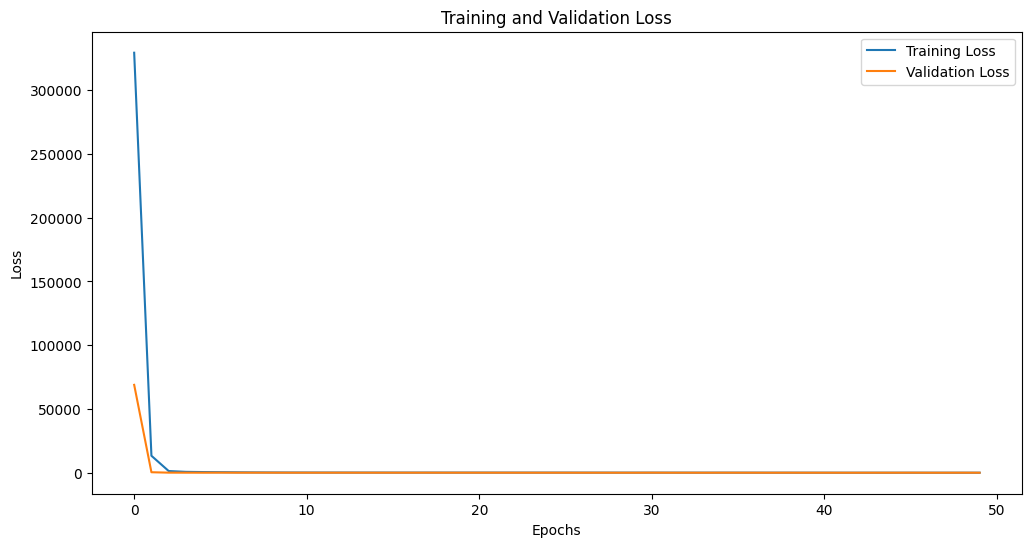

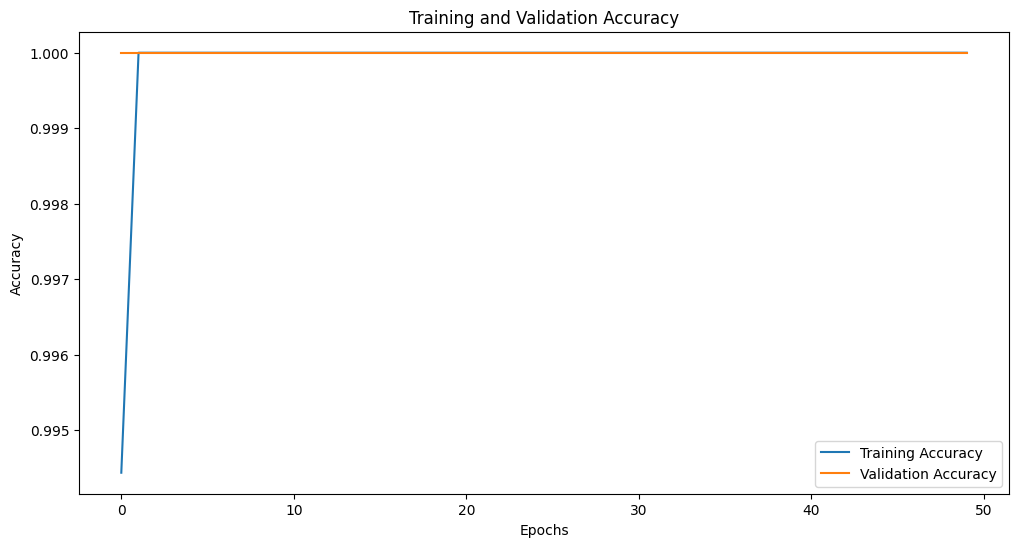

In [113]:
import matplotlib.pyplot as plt

# 绘制训练与验证损失曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制训练与验证准确度曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 6. 测试

In [114]:
model = load_model(f'models/best_erp_lstm_model_{current_time}.keras', custom_objects={'Attention': Attention})

2024-10-15 17:04:24,905 - WARNING - At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.


In [115]:
# 测试集上的预测结果
def plot_predictions(model, X, y, start=0, end=100):
  predictions = model.predict(X)
  p_preds, temp_preds = predictions[:, 0], predictions[:, 1]
  p_actuals, temp_actuals = y[:, 0], y[:, 1]
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  plt.plot(df['Temperature Predictions'][start:end])
  plt.plot(df['Temperature Actuals'][start:end])
  plt.plot(df['Pressure Predictions'][start:end])
  plt.plot(df['Pressure Actuals'][start:end])
  return df

159/159 [==============================] - 5s 8ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,12.249736,12.93,982.792786,982.43
1,11.910052,12.43,982.846497,982.68
2,11.714067,12.17,983.002380,983.02
3,11.672297,11.55,983.284973,983.59
4,11.551541,11.59,983.883789,983.59
...,...,...,...,...
5079,0.393382,-0.98,1003.876038,1002.18
5080,-0.853481,-1.40,1003.707520,1001.40
5081,-1.619785,-2.75,1003.109741,1001.19
5082,-2.382580,-2.89,1002.736816,1000.65


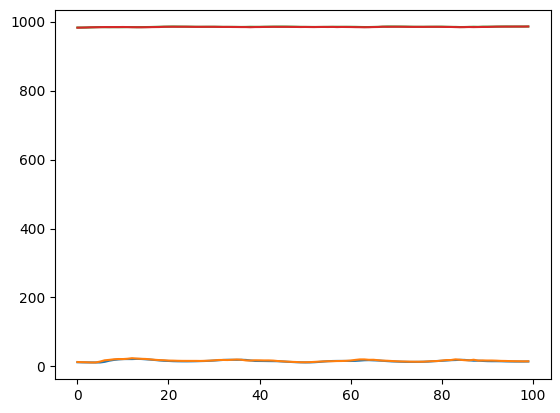

In [116]:
plot_predictions(model, X_test, y_test)

In [117]:
# 后处理
def postprocess_temp(arr):
  arr = (arr*temp_training_std) + temp_training_mean
  return arr

def postprocess_p(arr):
  arr = (arr*p_training_std) + p_training_mean
  return arr

In [118]:
def get_predictions_postprocessed(model, X, y):
  predictions = model.predict(X)
  p_preds, temp_preds = postprocess_p(predictions[:, 0]), postprocess_temp(predictions[:, 1])
  p_actuals, temp_actuals = postprocess_p(y[:, 0]), postprocess_temp(y[:, 1])
  df = pd.DataFrame(data={'Temperature Predictions': temp_preds,
                          'Temperature Actuals':temp_actuals,
                          'Pressure Predictions': p_preds,
                          'Pressure Actuals': p_actuals
                          })
  return df

In [119]:
post_processed_df = get_predictions_postprocessed(model, X_test, y_test)
post_processed_df

159/159 [==============================] - 1s 8ms/step


,Temperature Predictions,Temperature Actuals,Pressure Predictions,Pressure Actuals
0,12.249736,12.93,982.792786,982.43
1,11.910052,12.43,982.846497,982.68
2,11.714067,12.17,983.002380,983.02
3,11.672297,11.55,983.284973,983.59
4,11.551541,11.59,983.883789,983.59
...,...,...,...,...
5079,0.393382,-0.98,1003.876038,1002.18
5080,-0.853481,-1.40,1003.707520,1001.40
5081,-1.619785,-2.75,1003.109741,1001.19
5082,-2.382580,-2.89,1002.736816,1000.65


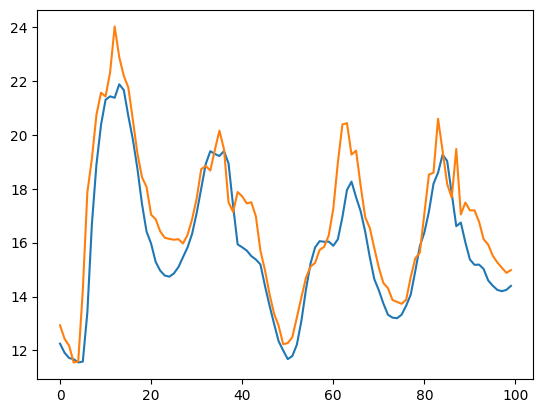

In [120]:
start, end = 0, 100
plt.plot(post_processed_df['Temperature Predictions'][start:end])
plt.plot(post_processed_df['Temperature Actuals'][start:end])

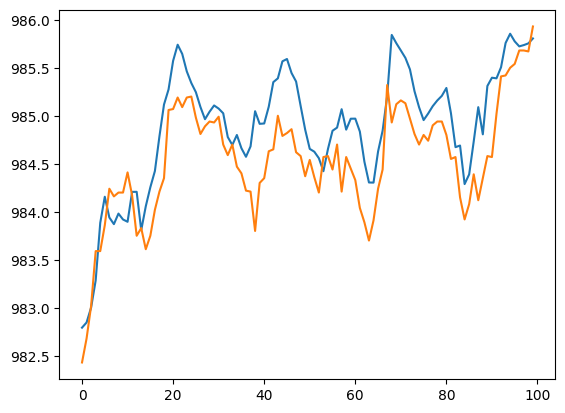

In [121]:
plt.plot(post_processed_df['Pressure Predictions'][start:end])
plt.plot(post_processed_df['Pressure Actuals'][start:end])

In [123]:
## 导出xlsx文件
post_processed_df.to_excel('post_processed_df.xlsx', index=False)

## 7. 查看TensorBoard 实验日志结果

In [124]:
%load_ext tensorboard
%tensorboard --logdir tb_results


## 8. ONNX模型推理用例

In [135]:
import onnx
import onnxruntime as ort
import numpy as np

# 加载 ONNX 模型
onnx_model = onnx.load(f'models/best_erp_lstm_model_{current_time}.onnx')

# 检查模型是否有效
onnx.checker.check_model(onnx_model)

# 创建 ONNX Runtime 会话
ort_session = ort.InferenceSession(f'models/best_erp_lstm_model_{current_time}.onnx')

# 准备输入数据（根据实际情况调整）
input_name = ort_session.get_inputs()[0].name
input_data = np.random.random((1, 7, 6)).astype(np.float32)

# 执行预测
outputs = ort_session.run(None, {input_name: input_data})
print("onnx预测结果:", outputs)


onnx预测结果: [array([[994.2083  ,  13.447922]], dtype=float32)]
